### Uplift моделирование(анализ)

Задача uplift - это к примеру то, как понять, нужно ли взаимодействовать с пользователем для увеличения конверсии или наоборот

Часто возникает необходимость коммуникации с пользователями для продвижения сервисов и услуг.

Коммуникация осуществляется с помощью различных каналов: смс, звонки, push-уведомления, сообщения в чатботе и т.д

Например, мы хотим отправить push-уведомление игрокам в мобильной игре о том, что у них заполнились склады или об ином внутриигровом событии. Либо даже хотим отправить уведомление о наступающем внутриигровом эвенте (которые очень важны для активных игроков и для монетизации и развития игры в целом).

Другой пример:

Мы хотим прорекламировать популярный продукт, но при этом не хотим тратить бюджет на коммуникацию с пользователями, которые и без нас его купят.

#### Мы сделали классификацию пользователей на предмет оттока. Теперь логичным было бы попробовать предложить  клиентам оттока какие-либо бонусы, показать свою лояльность, пересмотреть условия договора и т.д.


Но тут нас ждет еще одна задача. Не всем нравятся назойливые звонки/смс/push и т.д.

Тоесть среди наших "несчатных" пользователей есть те, звонок которым лишь сильнее внушит им отторжение сервиса. Также есть те, на счет которых мы ошиблись при классификации по оттоку, и они и так остались бы с нами.

#### По реакции на коммуникацию пользователи делятся на 4 типа: 
1. Пользователи, которые совершат нужное действие независимо от коммуникации
2. Те, кто совершат действие, если будет коммуникация
3. Те, кто не совершит действие независимо от коммуникации
4. Не совершат действие, если коммуникация будет

#### Значит, наша задача - попытаться понять, кому стоит звонить, а кому нет. Тоесть сделать разделение пользователей
#### Тогда мы будем работать по след схеме:
Необходимо оценить разницу между двумя событиями, которые являются взаимоисключающими для конкретного пользователя.

Для этого нам нужна обучающая выборка. А для нее нужно просто провести эксперимент. 

1. Берем часть базы пользователей и разбиваем на 2 группы: контрольную и экспериментальную
2. На экспериментальной группе запускаем маркетинговую кампанию (совершаем коммуникацию)
3. Через какое-то время у нас есть результаты совершения нужного действия клиентами в обеих группах (включая контрольную)
4. Проводим uplift-моделирование

#### Формула ниже, это вероятность нужного на действия пользователя с нашим "звонком" - вероятность нужного нам действия без нашего "звонка"
![ab_split](uplift_3.png "uplift3")

### Для решения этой задачи есть 2 метода:
#### 1.Модель с дополнительным признаком(Treatment Dummy approach, Solo model approach, Single model approach, S-Learner )
Тут мы берем: 
* X - вектора, которые описывают наших клиентов
* W - фактор оказания/не оказания воздействия(1,0)
* Y - результат оттока( вернулся или не вернулся)

Теперь нам нужно посчитать вероятности uplift

Для этого мы делаем всю выборку с w = 1 и всю выборку с w = 0, обучаем модель и берем разницу вероятностей(как на картинке), это и будет наш uplift. Далее мы ранжируем uplift по убыванию и начинаем обзванивать клиентов по убыванию вероятности.
![ab_split](uplift_single_model.png "uplift_single_model")

#### 2. Две независимые модели
Мы берем 2 модели с идентичными данными, разделив в плане воздействия.
Тоесть первую берем ту,где было воздействие, а вторую, где не было

Интуитивно понятный и простой метод - моделируем 2 условные вероятности

1. обучаем модель прогноза вероятности совершения целевого действия для контрольной группы
2. обучаем модель прогноза вероятности совершения целевого действия для экспериментальной группы
3. на прогнозе - делаем прогноз для тестовых пользователей двумя моделями и вычитаем из прогноза второй модели прогноз первой

Далее мы подаем наших клиентов в обе модели и при вычитании вероятностей имеем uplift


![ab_split](uplift_2models.png "uplift_2models")

1. Проблема этого подхода в том, что мы построили 2 разные модели. Соответственно они должны быть одного класса и похожими по гиперпараметрам, иначе на выходе из моделей мы будем получать не бъющиеся между собой скоры
2. Нужно проводить калибровку моделей

### Применим на практике
Для работы нам понадобится пакет scikit-uplift и causalml

In [1]:
#!pip install catboost #- узнать версию конкретного пакета
#!pip install scikit-uplift catboost==0.24.2 -U #установка uplift для конкретной версии catboost
#!pip install causalml

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
df_clietns = pd.read_csv('/gdrive/MyDrive/clients.csv', index_col='client_id')
df_train = pd.read_csv('/gdrive/MyDrive/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('/gdrive/MyDrive/uplift_test.csv', index_col='client_id')
df_clietns.head(3)

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F


Данных не так много. Лишь время регистрации и время первого действия.

Надо перейти к более удобным представлениям данных

In [4]:
df_features = df_clietns.copy()
# превратим время с момента регистрации в кол-во секунд начиная с 1970 г.
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date']) - pd.Timestamp('1970-01-01'))\
    // pd.Timedelta('1s')

# превратим время с момента первого действия в кол-во секунд начиная с 1970 г.
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# создадим производный признак, который определяет разницу между временем первого совершенного действия и момента регистрации
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']

# перейдем к более удобным признакам, удалив ненужные
df_features = df_features.drop(columns=['first_issue_date','first_redeem_date'], axis=1)

In [5]:
# возьмем индексы клиентов тернировочного и тестового наборов
indices_train = df_train.index
indices_test = df_test.index
# разобьем индексы тренировочного сета на учебный и валидный
indices_learn, indices_valid = train_test_split(df_train.index, test_size = 0.3, random_state = 42)

In [6]:
# исходное представление
df_clietns

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
...,...,...,...,...
fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F
ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F


In [7]:
# новое представление
df_features.head(3)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN


In [8]:
# индексы клиентов теста
df_test.head(3)

""
client_id
000048b7a6
000073194a
00007c7133


In [9]:
# индексы клиентов, флаг наличия воздействия, эффект оттока
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [10]:
# посмотрим на сколько наша задача неуравновешена
df_train.groupby('treatment_flg')['target'].describe()
# баланс довольно хороший, 100000 на кого воздействовали и около 100000 на кого нет

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


Теперь разделим на трейн, валид и тест в зависимости от наших индексов

In [11]:
# берем из нашего нового пространства признаков вектора, индексы которых мы разметили под обучение
X_train = df_features.loc[indices_learn, :]
# те же индексы берем из датафрейма с известными флагами воздействия и целевой переменной, тоесть берем целевую переменную
y_train = df_train.loc[indices_learn, 'target']
# из того же датасета берем признак воздействия, был или нет
treat_train = df_train.loc[indices_learn, 'treatment_flg']

Тоже самое проделаем с для валидационных данных

In [12]:
X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

Строим трейны для полной модели, тоесть включающую все индексы тренировочного набора

In [13]:
X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

Строим X_test

In [14]:
X_test = df_features.loc[indices_test, :]

Разделим признаки на числовые, категорийные и тд.

У нас один категорийный - gender

In [15]:
cat_features = ['gender']

Когда будем фиксировать результаты модели, нам важно знать вариант используемой модели и результат uplift

Создадим словарь для результатов

In [16]:
models_results = {'approach' : [], 
                  'uplift@30%': []}

Создадим функция для визуализации результатов и лучшего понимания происходящего

In [17]:
from sklearn.utils.validation import check_consistent_length
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

### 1. Подход с одной моделью

In [18]:
from sklift.metrics import uplift_at_k
#from sklift.viz import plot_uplift_preds в новой версии некорректно работает, потом и своя функция
from sklift.models import SoloModel # класс для построения uplift с одной моделью

In [19]:
# sklift поддерживает любые модели, которые удовлетворяют соглашениями scikit-learn

# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

Создадим модель.

В SoloModel мы передаем решатель - CatBoost

In [20]:
N =10000
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
# в фит мы должны передать 3 аргумента
# X - описание векторов, y которые отвечают на результат после того как мы сделали treatment, и само наличие treatment
sm = sm.fit(X_train.iloc[:N,:], y_train.iloc[:N], treat_train.iloc[:N], estimator_fit_params={'cat_features': cat_features})
# делаем предикты валидационного набора, которые впоследствии отсортируем от более желательных к менее желательным
uplift_sm = sm.predict(X_val)

# метрика для uplitf
# передаем валидационные y, предсказанный uplift для тех-же самых объектов, информацию о воздейтсвии на те-же объекты
# k - оценка в процентах, сколько брать по uplift, это можно интерпретировать как какое-то кол-во денег мы готовы потратить
# на вмешательства(больше или меньше)
# ЭТОТ СКОР ЭТО ОЦЕНКА ВОЗДЕЙСТВИЯ, КОТОРАЯ ОЦЕНИВАЕТ ЭФФЕКТ ОТ ВОЗДЕЙСТВИЯ
sm_score = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.3)

# Добавим модель в наш словарь
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [21]:
models_results

{'approach': ['SoloModel'], 'uplift@30%': [0.07230889249446715]}

Мы получили uplift в 7%

Можно сказать, что если бы мы не "звонили", то получили бы отток примерно на 7% больше

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3200174b10>,
      dtype=object)

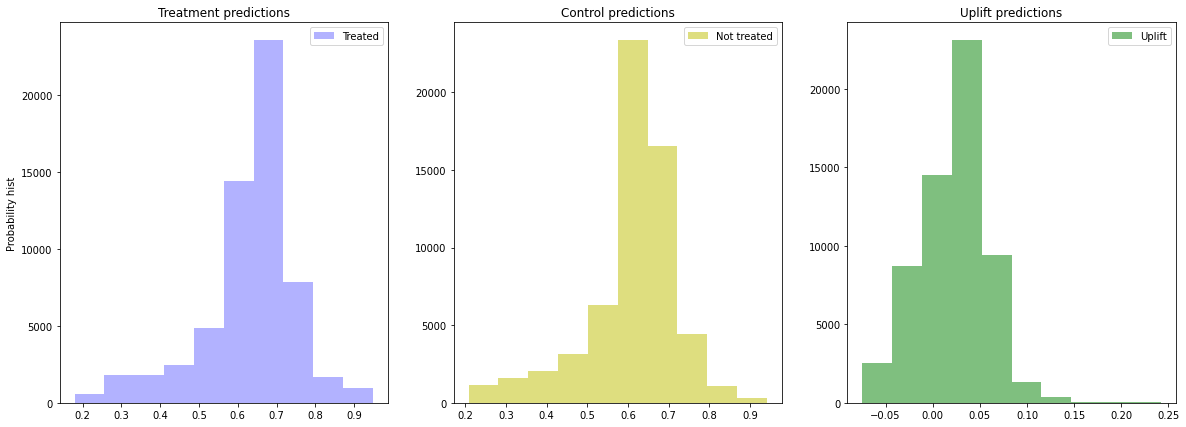

In [22]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отобразим распределения вероятностей и их разность (uplift)
plot_uplift_preds_(sm_trmnt_preds , sm_ctrl_preds, bins=10)#ctrl_preds=

1. Первый график - это график с воздействием. Тут мы оцениваем вероятность того, что наш клиент совершит нужное действие при воздействии на него с помощью "звонка"
2. Второй график - это график без воздействия. Вероятность того, что клиент совершит необходимое дейтвие без "звонка"
3. Третий грфик - это их разница. Интрепретировать можно как стоит звонить/не стоит звонить (относительно 0)

Таким образом, наша задача это выбор из подмножества > 0(на 3 графике)   30% клиентов для мотивирующих предложений

Мы построили одну общую модель на два варианта решения( с воздействием/ без воздействия). При этом в трейне мы использовали клиентов, которые подвергались или не подвергались воздействию. При обучении SoloModel мы сначала обучили всю выборку на treatment = 1, затем на treatment=0, после чего нашли разницу вероятностей(3 график)

In [23]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,33.241807
1,issue_redeem_delay,29.979409
2,age,13.100289
3,first_issue_time,11.459948
4,gender,7.064859
5,treatment,5.153688


### 2. Подход с двумя моделями

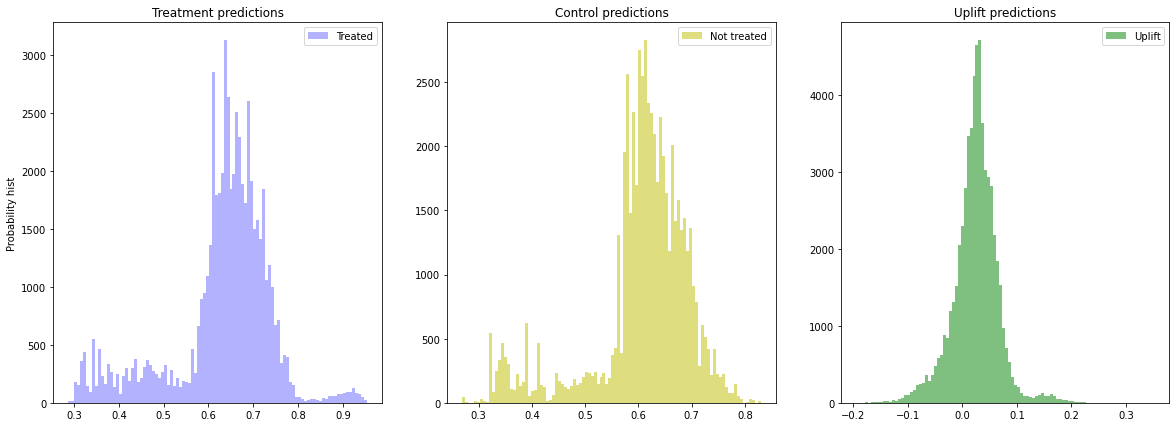

In [24]:
from sklift.models import TwoModels # импорт двух моделей

# В TwoModels передаем оба оценщика с ОДИНАКОВЫМИ гиперпараметрами
# На выходе получим две независимых модели
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
# Тренируем, также передавая X, результат воздействия, наличие воздействия
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

# Предикты
uplift_tm = tm.predict(X_val)

# Используем ту же метрику
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

# Добавляем нашу модель
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# Отобразим результаты на графике
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [25]:
models_results

{'approach': ['SoloModel', 'TwoModels'],
 'uplift@30%': [0.07230889249446715, 0.07365091398330947]}

Независимые модели нуждаются в коррекции самих моделей!

### 3. Подход с трансформацией класса

В данном подходе нам нужно найти тех клиентов, которые интересуют нас как цель.

В таком случае можно попробовать решить пробему, опираясь на трансформацию классов.

Мы строим агрегированный целевой признак, который будет объединять между собой ситуации воздействия и результата + отсутвие воздействия и отсутвие результата.

Иными словами это про тех, кого мы потеряем если не позвоним, и про тех, кому мы позвонили и он остался.
В этом случае наше Z = 1, во всех остальных наше Z будет равно 0
![ab_split](uplift5.png "uplift5")

In [26]:
from sklift.models import ClassTransformation # трансформация классов


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


Данные способ рекомендуется использовать со сбалансированными данным с точки зрения воздействия. В нашем же примере данные не сбалансированны

### 4. Подход с деревьями решений

!pip install causalml - пакет, который ориентирован на решения задач объяснения ситуации. Он пытается рассказать, почему мы приняли такие решения и куда нам следует обращаться, чтобы оценить что мы увидели

In [27]:
from IPython.display import Image, display
# Регрессор и классификатор из пакета
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
X_train_tree = pd.concat([X_train.drop('gender', 1), 
                          pd.get_dummies(X_train['gender'], prefix='gender')], 1)
X_val_tree = pd.concat([X_val.drop('gender', 1), 
                          pd.get_dummies(X_val['gender'], prefix='gender')], 1)
features = [col for col in X_train_tree]

invalid value encountered in greater_equal


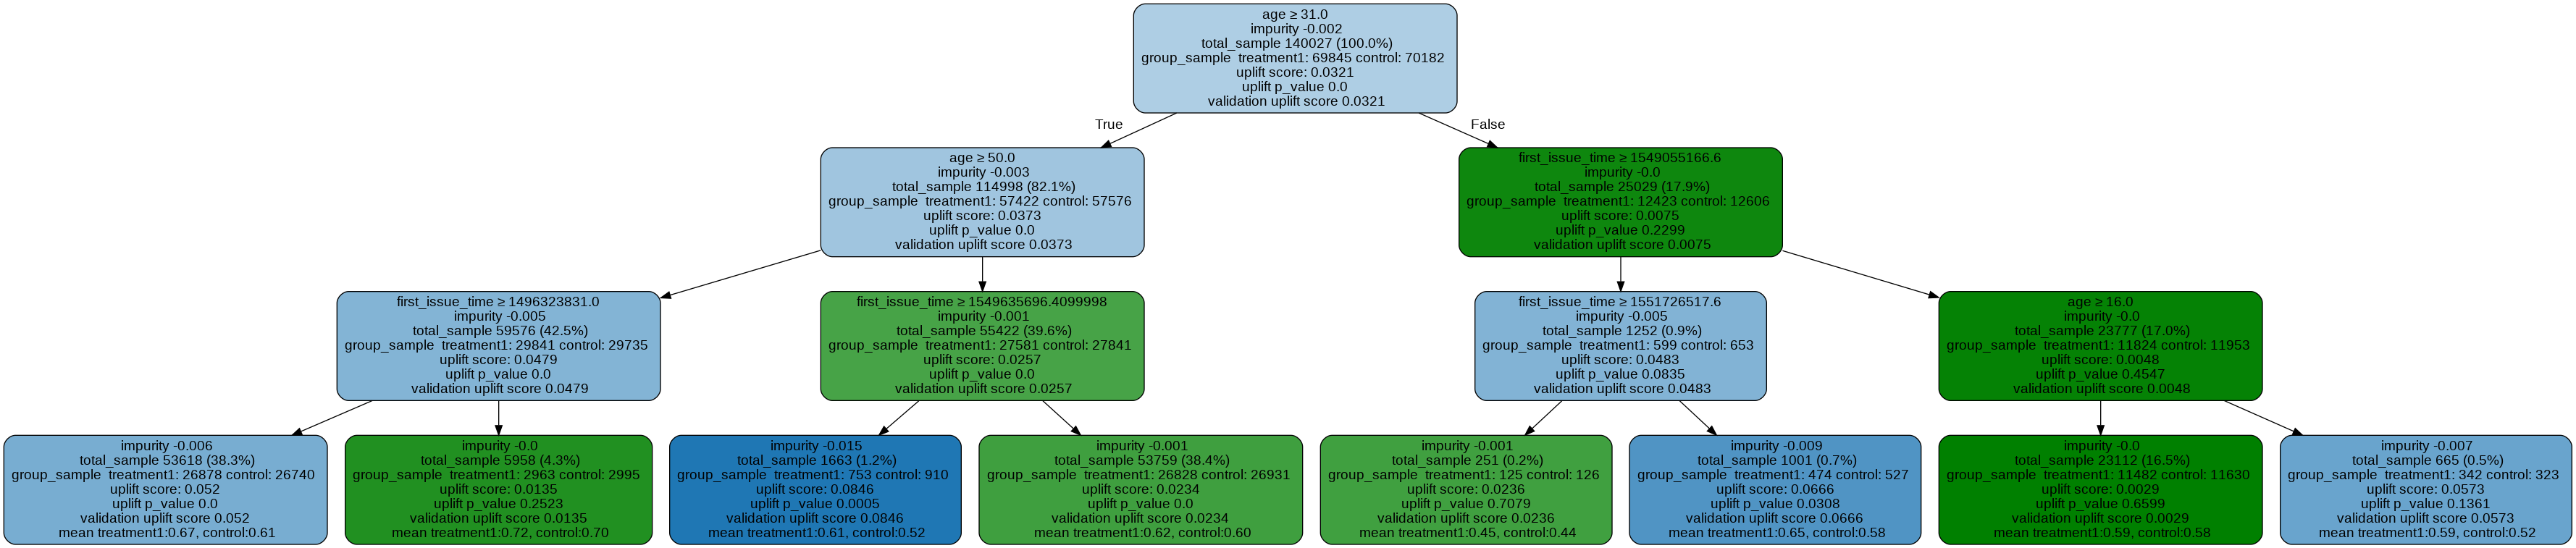

CPU times: user 6.86 s, sys: 116 ms, total: 6.98 s
Wall time: 7.28 s


In [29]:
%%time
# построит дерево, где каждая вершина будет взвешена информацией о том, почему мы приняли такое решение и как это решение
# мы будем оценивать
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')
# min_samples_leaf=200 - кол-во примеров на узел
# evaluationFunction='KL' - метрика кульбака-лейблера, относительно которой мы проводим оценку
# Она связывает разные распределения и позволяет определить расстояние между этими распределениями

# treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values заменяем значения для более лучшего понимания
uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

# Оцениваем каждый узел дерева с точки зрения фактора uplift
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
# Построим узлы дерева
display(Image(graph.create_png()))

Смотрим на листы по:
1. Смотрим на кол-во объектов в листе(сколько данных лист описывает)
2. Смотрим на семплирование типа group_sample по treatment и control
3. validation uplift score - это наша конверсия(тоесть чем больше этот показатель тем больше пользы будет от звонка)
3. Смотрим на uplift_score, который должен быть больше, а p_value меньше

К объектам, у которых validation uplift score близок к 0 или вообще отрицательный лучше не применять какое-либо воздействие

In [30]:
tree_lift =  np.array(uplift_model.predict(X_val_tree.values))[0]

uplift_tree_30 = uplift_at_k(y_val, tree_lift, treat_val, strategy='overall')
print(f'uplift@30%: {uplift_tree_30:.4f}')
models_results['approach'].append('TreeModels')
models_results['uplift@30%'].append(uplift_tree_30)

uplift@30%: 0.0369


In [31]:
# Посмотрим на наши модели
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,TwoModels,0.073651
0,SoloModel,0.072309
2,ClassTransformation,0.065942
3,TreeModels,0.036874


Сделаем пайплайн облаботки для дерева на основе causalml

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if len(self.column)==1:
          return X[:,self.column].reshape( -1,1)
        else:
          return X[:, self.column] 

In [33]:
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

In [34]:
class PandasFeatureUnion(FeatureUnion):
    '''
    применить разные преобразования к разным столбцам,
    а затем объединить их вместе для дальнейшей обработки / процесса машинного обучения
    '''
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
    
class FeatureSelectorPd(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.column)
        return X[self.column]


    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        print('ohe')
        result = pd.get_dummies(X, prefix=self.key)
        for col_ in self.columns:
            if col_ not in result.columns:
                result[col_] = 0
        return result[self.columns]

In [35]:
from sklearn.pipeline import Pipeline

encoder1 =Pipeline([('ohe',OHEEncoder(['gender']))])

estimator = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
ct = ClassTransformation(estimator=estimator)




my_pipeline = Pipeline([
    ('encoder', PandasFeatureUnion([('1',encoder1)])),
    ('model',ct)
])



my_pipeline = my_pipeline.fit(   X=X_train, y = y_train, model__treatment=treat_train)


ohe


It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [36]:
uplift_predictions = my_pipeline.predict(X_val)

uplift_30 = uplift_at_k(y_val, uplift_predictions, treat_val, strategy='overall')
print(f'uplift@30%: {uplift_30:.4f}')

ohe
uplift@30%: 0.0643


In [37]:
models_results['approach'].append('ClassTransformation-pipeline')
models_results['uplift@30%'].append(uplift_30)

In [38]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,TwoModels,0.073651
0,SoloModel,0.072309
2,ClassTransformation,0.065942
4,ClassTransformation-pipeline,0.064255
3,TreeModels,0.036874
